In [ ]:
# default_exp traj_to_meas

# Trajectories to Measurment of Derivatives

> This module contains the core functionality of the reconstruction. Given input trajectories and a time array, return an ODE object that contains the numerical ODEs and that can be solved with some other method

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from time import time
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

from scipy.integrate import odeint 
from numpy.random import permutation,rand,randn

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model
from sklearn.feature_extraction.image import PatchExtractor as PE

from functools import partial,reduce

In [ ]:
#hide
%matplotlib inline

## Helper Functions to prepare a data set for testing
> This can be repackaged later too

In [ ]:
#export 
def rand_par(par,cvar):
    '''This function adds gaussian noise to parameters (means) stored in a dictionary. 
    Input
        par: dictionary of ODE parameters which constitute the means
        cvar: coeficient of variation of the distributon that each parameter will be sampled from (1 = 100% of the not noisy value).
    return
        dictionary with parameters sampled from gaussian around parameter means (inputs) or zero, if sampled value is negative
        '''
    temp = par.copy()
    for key in temp.keys():
        temp[key]=par[key]*(1+cvar*randn())
        if temp[key] < 0:
            temp[key] = 0         
    return temp  

In [ ]:
rand_par({"A": 2},0.3)

{'A': 0.6118780579904304}

### Example - Harmonic Oscillator

In [ ]:
def HOder(y,t,p):
    
    der = np.array([0*y[0]+1/p['m']*y[1],-p['k']*y[0]])
    return der

HOpar = dict(m=2,k=1)

In [ ]:
#export
def traj_solve(N,dt,model_der,mod_par,cvar):
    '''Solve N trajectories with time delta dt for model given in model_der with parameters mod_par
    and coefficient of variation cvar'''
    t0 = 0
    tend = 100
    Nt = round((tend-t0)/float(dt))
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the paramters
        rlvpar = rand_par(mod_par,cvar)
        yinit = rand(2)*np.array([3,0])
        traj[i,:,:] = odeint(model_der,yinit,time,args = (rlvpar,))
    return traj,time    

#### Sample Trajectories

In [ ]:
N=10
traj,time = traj_solve(N,0.1,HOder,HOpar,0.0)

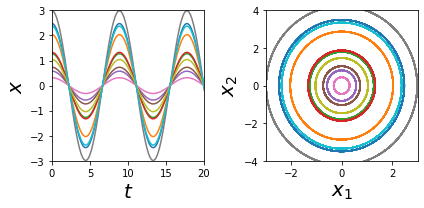

In [ ]:
f,axes = plt.subplots(1,2,figsize=(6,3))
for i in range(N):
    axes[0].plot(time[:],traj[i,:,0])
    axes[1].plot(traj[i,:,0],traj[i,:,1])
axes[0].set_xlabel("$t$",size = 20)
axes[0].set_ylabel("$x$",size =20)
axes[0].set_xlim((0,20))
axes[0].set_ylim((-3,3))
    
    
axes[1].set_xlabel("$x_1$",size = 20)
axes[1].set_ylabel("$x_2$",size =20)
axes[1].set_xlim((-3,3))
axes[1].set_ylim((-4,4))
plt.tight_layout()  
#savefig("HO_example.pdf",transparent = True)

In [ ]:
#export 
class traj_2_measurement:
    def __init__(self,traj,time,grid_size=100,domain_fct = 1.1):
        '''Domain factor extrapolates out the variable domains beyond the observed values. 1.1 = 10% increase'''
        self.domain_fact = domain_fct
        self.n_traj,self.n_time,self.n_dim=self.infer_dims(traj)
        self.xs_min,self.xs_max,self.t_min,self.t_max = self.infer_domains(traj,time)
        self.grid_size=grid_size
        self.xs2inds,self.inds2xs = self.create_ind_x_mappings()
        self.f_ms = self.create_f_ms(traj,time,Ntraj_sample=self.n_traj)
        
    def infer_dims(self,traj):
        return traj.shape
    
    def create_f_ms(self,traj,time,Ntraj_sample):
        trajder = self.traj_der(traj,time)
        f_ms = [self.traj_to_f_m(traj,trajder,Ntraj_sample,i) for i in range(self.n_dim)]
        return f_ms

    def traj_to_f_m(self,traj,trajder,Ntraj_sample,dim_ind):
        N,Nt,Nvar = self.n_traj,self.n_time,self.n_dim
        f_m = np.full((self.grid_size,)*2,np.nan)
        touched = np.full((self.grid_size,)*2,0.)
        s = sorted(np.random.permutation(N)[:Ntraj_sample])
        inds = [-1]*Nvar
        for k in s:
            for i in range(Nt-1):
                for l in range(Nvar):
                    inds[l] = self.xs2inds[l]((traj[k,i+1,l]+traj[k,i,l])/2.)
                #make sure index fits into the array
                lt_grid_size = list(map(lambda x:x<self.grid_size,inds))
                gte_zero = list(map(lambda x:x>-1,inds))
                if reduce(lambda x,y: x and y,lt_grid_size+gte_zero):
                    if touched[tuple(inds)] == 0.:
                        f_m[tuple(inds)] = trajder[k,i,dim_ind]
                    else:    
                        f_m[tuple(inds)] += trajder[k,i,dim_ind]

                    touched[tuple(inds)] +=1.

        f_m[touched!=0.]/=touched[touched!=0.]
        return f_m

    def create_ind_x_mappings(self,ind2x_func=None,x2ind_func=None):
        '''create mappings from xs to indexes on the grid and vice versa'''
        x2ind_func = x2ind_func if x2ind_func else self.lin_x2ind
        xs2inds = {j:partial(self.lin_x2ind,x_min=self.xs_min[j],x_max=self.xs_max[j],grid_size=self.grid_size) 
                   for j in range(self.n_dim)}
        inds2xs = {j:partial(self.lin_ind2x,x_min=self.xs_min[j],x_max=self.xs_max[j],grid_size=self.grid_size) 
                   for j in range(self.n_dim)}
        return xs2inds,inds2xs

    def infer_domains(self,traj,time):
        '''Infer domains for variables x and time t'''
        xs_min,xs_max = np.min(traj,axis=(0,1))*self.domain_fact,np.max(traj,axis=(0,1))*self.domain_fact
        t_min,t_max = np.min(time),np.max(time)
        return xs_min,xs_max,t_min,t_max
    
    def traj_der(self,traj,time):
        '''Vectorized computation of derivatives with respect to time
        as a first order approx, i.e., f` approx delta f/delta t
        '''
        trajder = (traj[:,1:,:]-traj[:,:-1,:])/((time[1:]-time[:-1])[None,:,None])
        return trajder  
    
    def lin_ind2x(self,i,x_min,x_max,grid_size):
        '''Linear transformation from index to x domain'''
        assert(i<grid_size)
        assert(i>=0)
        return x_min + i*(x_max-x_min)/(grid_size-1)

    def lin_x2ind(self,x,x_min,x_max,grid_size):
        '''Linear transformation from x domain to index'''
        ind = (x-x_min)/(x_max-x_min)*(grid_size-1)
        if ind<0:
            ind=0
        elif ind>grid_size-1:
            ind=grid_size-1
        return int(round(ind))    

In [ ]:
t2m = traj_2_measurement(traj,time)

assert((10,1000,2)==(t2m.n_traj,t2m.n_time,t2m.n_dim))
print(t2m.t_min,t2m.t_max,t2m.xs_min,t2m.xs_max)
print(t2m.grid_size)

0.0 100.0 [-3.28400301 -4.64426621] [3.28400235 4.64426161]
100


The above result indicates that we have 10 trajectories (i.e. solutions to an ODE) with 1000 time points each, in a 2 dimensional system.

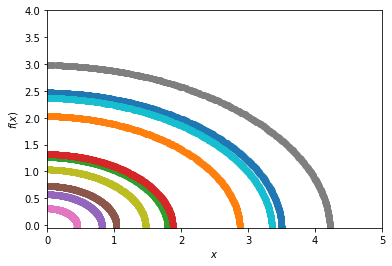

In [ ]:
trajder = t2m.traj_der(traj,time)
for i in range(N):
    plt.plot(traj[i,:-1,1],trajder[i,:,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.xlim((0,5))
    plt.ylim((-0.05,4))

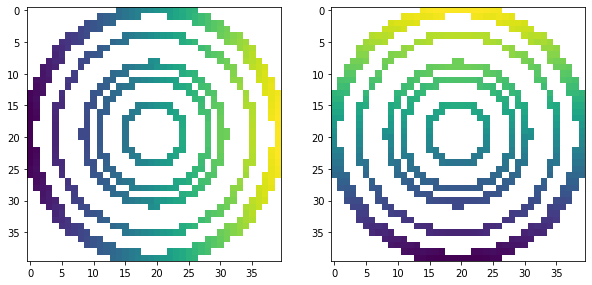

In [ ]:
f,ax=plt.subplots(1,2,figsize=(10,22))
ax[0].imshow(t2m.f_ms[0][30:70,30:70])
ax[1].imshow(t2m.f_ms[1][30:70,30:70])